# Trabalho Prático 2

## Import Bibliotecas

In [153]:
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from sklearn.preprocessing import MinMaxScaler
#from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA


## Dataset

In [154]:
df = pd.read_csv('student-data.csv')  
df['passed'] = df['passed'].map({'yes': 1, 'no': 0})
df


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,passed
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,no,no,4,3,4,1,1,3,6,0
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,yes,no,5,3,3,1,1,3,4,0
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,yes,no,4,3,2,2,3,3,10,1
3,GP,F,15,U,GT3,T,4,2,health,services,...,yes,yes,3,2,2,1,1,5,2,1
4,GP,F,16,U,GT3,T,3,3,other,other,...,no,no,4,3,2,1,2,5,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,MS,M,20,U,LE3,A,2,2,services,services,...,no,no,5,5,4,4,5,4,11,0
391,MS,M,17,U,LE3,T,3,1,services,services,...,yes,no,2,4,5,3,4,2,3,1
392,MS,M,21,R,GT3,T,1,1,other,other,...,no,no,5,5,3,3,3,3,3,0
393,MS,M,18,R,LE3,T,3,2,services,other,...,yes,no,4,4,1,3,4,5,0,1


In [155]:
print(df['passed'].value_counts())

passed
1    265
0    130
Name: count, dtype: int64


## Estatisticas Descritivas Basicas

In [156]:
# Calcula estatísticas descritivas para variáveis numéricas
numeric_df = df.select_dtypes(include=['number'])
mean = numeric_df.mean()
median = numeric_df.median()
std_dev = numeric_df.std()
skewness = numeric_df.skew()
kurtosis = numeric_df.kurt()

# Cria uma tabela com as estatísticas descritivas
descriptive_stats = pd.DataFrame({
    'Média': mean,
    'Mediana': median,
    'Desvio Padrão': std_dev,
    'Assimetria': skewness,
    'Curtose': kurtosis
})

# Exibe a tabela
print("\nTabela de Estatísticas Descritivas:\n", descriptive_stats)


Tabela de Estatísticas Descritivas:
                 Média  Mediana  Desvio Padrão  Assimetria    Curtose
age         16.696203     17.0       1.276043    0.466270  -0.001222
Medu         2.749367      3.0       1.094735   -0.318381  -1.090014
Fedu         2.521519      2.0       1.088201   -0.031672  -1.198539
traveltime   1.448101      1.0       0.697505    1.607029   2.344190
studytime    2.035443      2.0       0.839240    0.632142  -0.014432
failures     0.334177      0.0       0.743651    2.387026   5.004727
famrel       3.944304      4.0       0.896659   -0.951882   1.139772
freetime     3.235443      3.0       0.998862   -0.163351  -0.301807
goout        3.108861      3.0       1.113278    0.116502  -0.770250
Dalc         1.481013      1.0       0.890741    2.190762   4.759492
Walc         2.291139      2.0       1.287897    0.611960  -0.790845
health       3.554430      4.0       1.390303   -0.494604  -1.014078
absences     5.708861      4.0       8.003096    3.671579  21.719

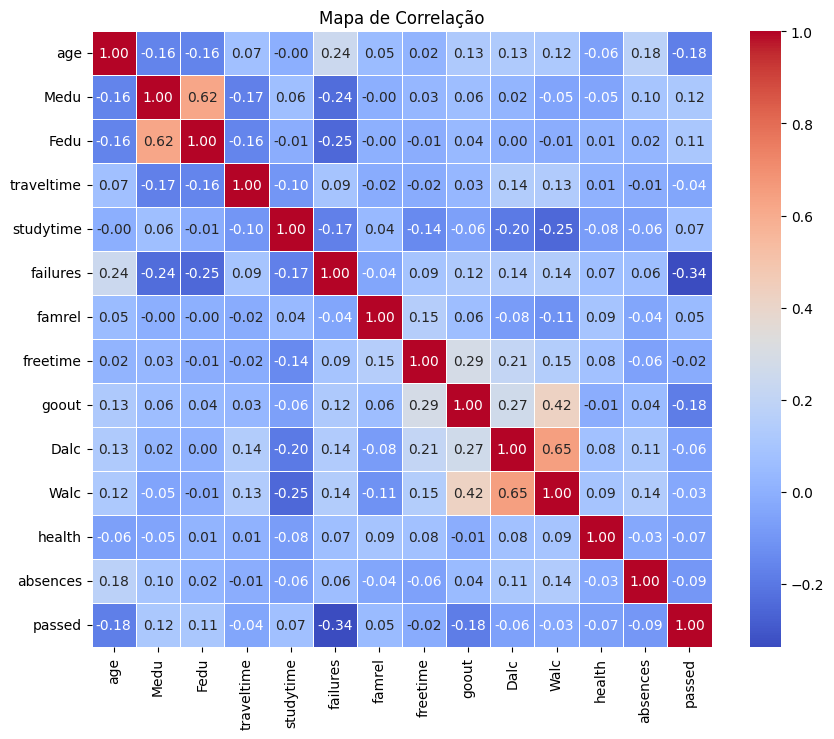

In [157]:
# Calcula a correlação entre as variáveis numéricas e a feature 'passed'
correlation_matrix = numeric_df.corr()

# Faz um mapa de calor para visualizar as correlações
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Mapa de Correlação')
plt.show()

In [158]:
from scipy.stats import chi2_contingency

# Seleciona colunas categóricas
categorical_columns = df.select_dtypes(include=['object']).columns

# Conta os valores únicos e exibe os resultados
for col in categorical_columns:
    value_counts = df[col].value_counts()


    # Função para verificar a relação entre variáveis categóricas e a feature 'passed'
    def check_relationship_with_passed(df, categorical_columns):
        for col in categorical_columns:
            contingency_table = pd.crosstab(df[col], df['passed'])
            chi2, p, dof, expected = chi2_contingency(contingency_table)

    # Chama a função para verificar as relações
    check_relationship_with_passed(df, categorical_columns)
    check_relationship_with_passed(df, ['guardian'])
    # Cria uma tabela para apresentar os resultados
    relationship_table = []

    for col in categorical_columns:
        contingency_table = pd.crosstab(df[col], df['passed'])
        chi2, p, dof, expected = chi2_contingency(contingency_table)
        relationship_table.append({'Variável': col, 'Chi2': chi2, 'p-valor': p, 'Relação Significativa': 'Sim' if p < 0.1 else 'Não'})

    # Converte a lista de resultados em um DataFrame
    relationship_df = pd.DataFrame(relationship_table)

    # Exibe a tabela
    print("\nTabela de Relações entre Variáveis Categóricas e 'passed':\n")
    print(relationship_df)


Tabela de Relações entre Variáveis Categóricas e 'passed':

      Variável      Chi2   p-valor Relação Significativa
0       school  0.206339  0.649652                   Não
1          sex  1.680311  0.194883                   Não
2      address  0.828878  0.362597                   Não
3      famsize  0.508995  0.475574                   Não
4      Pstatus  0.489916  0.483965                   Não
5         Mjob  5.303167  0.257581                   Não
6         Fjob  2.080416  0.720971                   Não
7       reason  4.493738  0.212850                   Não
8     guardian  5.318375  0.070005                   Sim
9    schoolsup  3.330694  0.067998                   Sim
10      famsup  1.138602  0.285948                   Não
11        paid  3.007571  0.082876                   Sim
12  activities  0.019497  0.888951                   Não
13     nursery  0.001761  0.966527                   Não
14      higher  8.353142  0.003850                   Sim
15    internet  1.176242  0

## Tratamento de Outliers

Número de outliers por coluna:
 age            1
Medu           0
Fedu           2
traveltime     8
studytime     27
failures      83
famrel        26
freetime      19
goout          0
Dalc          18
Walc           0
health         0
absences      15
passed         0
dtype: int64
Número de outliers severos por coluna:
 age            0
Medu           0
Fedu           0
traveltime     0
studytime      0
failures      83
famrel         0
freetime       0
goout          0
Dalc           0
Walc           0
health         0
absences       5
passed         0
dtype: int64


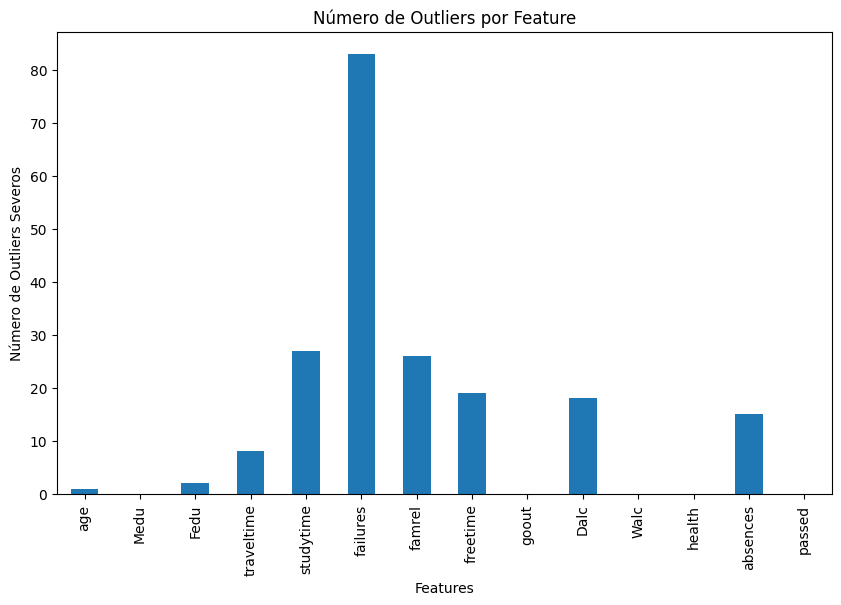

In [159]:
numeric_df = df.select_dtypes(include=['number'])
numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
numeric_df = df[numeric_cols]

# Identifica outliers usando o método do IQR
Q1 = numeric_df.quantile(0.25)
Q3 = numeric_df.quantile(0.75)
IQR = Q3 - Q1

# Define limites para outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Assinala os outliers por coluna
outliers = ((numeric_df < lower_bound) | (numeric_df > upper_bound))

# Conta o número de outliers por coluna
outliers_count = outliers.sum()
print("Número de outliers por coluna:\n", outliers_count)

# Identifica outliers severos usando o método do IQR
lower_bound_severe = Q1 - 3 * IQR
upper_bound_severe = Q3 + 3 * IQR

# Assinala os outliers severos por coluna
outliers_severe = ((numeric_df < lower_bound_severe) | (numeric_df > upper_bound_severe))

# Conta o número de outliers severos por coluna
outliers_severe_count = outliers_severe.sum()
print("Número de outliers severos por coluna:\n", outliers_severe_count)

# Faz um gráfico de barras com o número de outliers severos por feature
outliers_count.plot(kind='bar', figsize=(10, 6), title='Número de Outliers por Feature')
plt.xlabel('Features')
plt.ylabel('Número de Outliers Severos')
plt.show()

## Identificação dos outliers

In [160]:
# Resolve warnings by explicitly casting mean values to the appropriate dtype
for col in [c for c in numeric_cols if c not in ['failures', 'absences']]:
    non_severe_outliers = (numeric_df[col] < lower_bound[col]) | (numeric_df[col] > upper_bound[col])
    numeric_df.loc[non_severe_outliers, col] = mean[col].astype(numeric_df[col].dtype)

# Exibe o DataFrame após a imputação corrigida
print("DataFrame após imputação dos outliers não severos (corrigido):\n", numeric_df)

DataFrame após imputação dos outliers não severos (corrigido):
      age  Medu  Fedu  traveltime  studytime  failures  famrel  freetime  \
0     18     4     4           2          2         0       4         3   
1     17     1     1           1          2         0       5         3   
2     15     1     1           1          2         3       4         3   
3     15     4     2           1          3         0       3         2   
4     16     3     3           1          2         0       4         3   
..   ...   ...   ...         ...        ...       ...     ...       ...   
390   20     2     2           1          2         2       5         5   
391   17     3     1           2          1         0       3         4   
392   21     1     1           1          1         3       5         5   
393   18     3     2           3          1         0       4         4   
394   19     1     1           1          1         0       3         2   

     goout  Dalc  Walc  health  abs

# Algoritmos

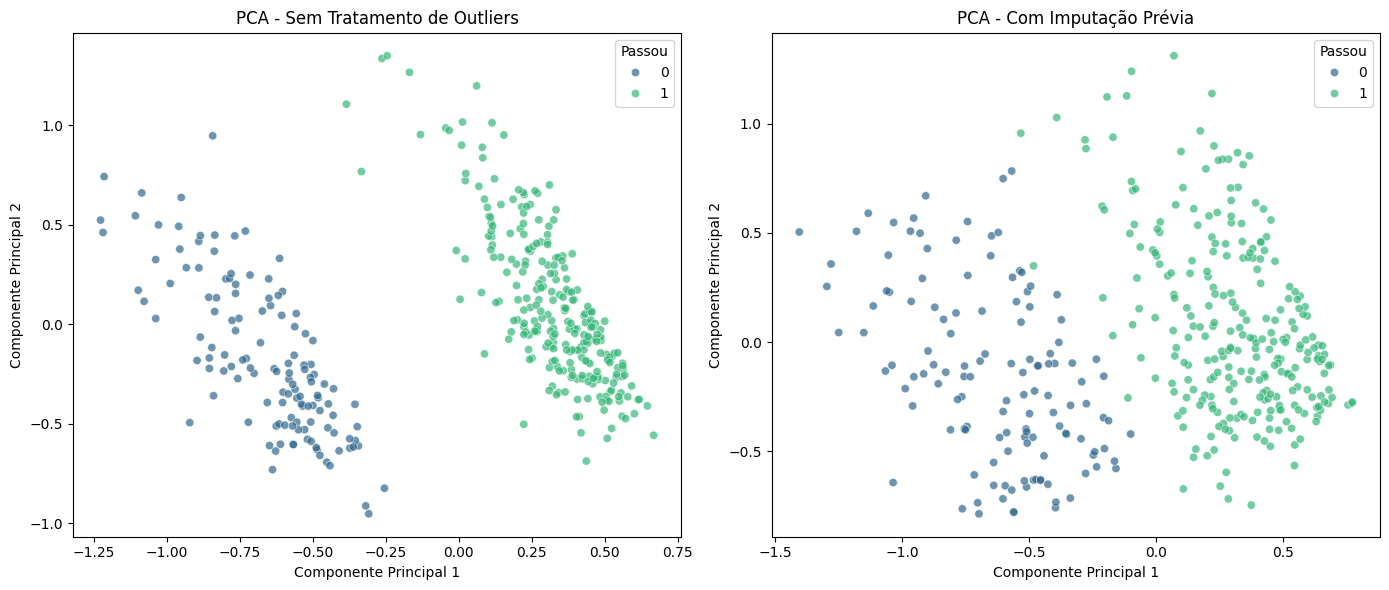

In [161]:
scaler = MinMaxScaler()
numeric_scaled_treated = scaler.fit_transform(numeric_df[numeric_cols])
numeric_scaled_original = scaler.fit_transform(df[numeric_cols])

# 9. Aplicação de PCA nos dados com imputação prévia
pca = PCA(n_components=2)
pca_result_treated = pca.fit_transform(numeric_scaled_treated)

# Criar DataFrame com os resultados do PCA (com imputação prévia)
pca_df_treated = pd.DataFrame(data=pca_result_treated, columns=['PC1', 'PC2'])
# Adiciona a coluna 'passed' para análise (assumindo que existe no df original)
pca_df_treated['passed'] = df['passed']

# 10. Aplicação de PCA nos dados originais para comparação
pca_original = PCA(n_components=2)
pca_result_original = pca_original.fit_transform(numeric_scaled_original)

# Criar DataFrame com os resultados do PCA (original)
pca_df_original = pd.DataFrame(data=pca_result_original, columns=['PC1', 'PC2'])
pca_df_original['passed'] = df['passed']

# 11. Visualização comparativa dos resultados PCA
plt.figure(figsize=(14, 6))

# Subplot para dados originais
plt.subplot(1, 2, 1)
sns.scatterplot(data=pca_df_original, x='PC1', y='PC2', hue='passed', palette='viridis', alpha=0.7)
plt.title('PCA - Sem Tratamento de Outliers')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(title='Passou')

# Subplot para dados com imputação prévia
plt.subplot(1, 2, 2)
sns.scatterplot(data=pca_df_treated, x='PC1', y='PC2', hue='passed', palette='viridis', alpha=0.7)
plt.title('PCA - Com Imputação Prévia')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(title='Passou')

plt.tight_layout()
plt.show()

In [162]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score
import numpy as np

# Separar as features e o target
X = numeric_scaled_original  # Dados sem tratamento de outliers
y = df['passed']  # Target

# Dividir o dataset em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Criar o modelo SVM
svm_model = SVC(kernel='linear', random_state=42)

# Treinar o modelo
svm_model.fit(X_train, y_train)

# Fazer previsões
y_pred = svm_model.predict(X_test)

# Avaliar o modelo
print("Acurácia:", accuracy_score(y_test, y_pred))
print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred))

# Verificar a distribuição das classes
print(y.value_counts())

# Validação cruzada para evitar erro de divisão de dados
scores = cross_val_score(svm_model, X, y, cv=5)
print("Validação cruzada acurácias:", scores)
print("Validação cruzada média de acurácia:", np.mean(scores))

Acurácia: 1.0

Relatório de Classificação:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        46
           1       1.00      1.00      1.00        73

    accuracy                           1.00       119
   macro avg       1.00      1.00      1.00       119
weighted avg       1.00      1.00      1.00       119

passed
1    265
0    130
Name: count, dtype: int64
Validação cruzada acurácias: [1. 1. 1. 1. 1.]
Validação cruzada média de acurácia: 1.0
